In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [5]:
strategy = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

2019-10-30 19:44:14,073 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:44:14,076 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:44:14,077 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [6]:
df_index = strategy.index.loc['1992':'2019-07']
df_index_return = strategy.ret.loc['1992':'2019-07']

# 2. Explore

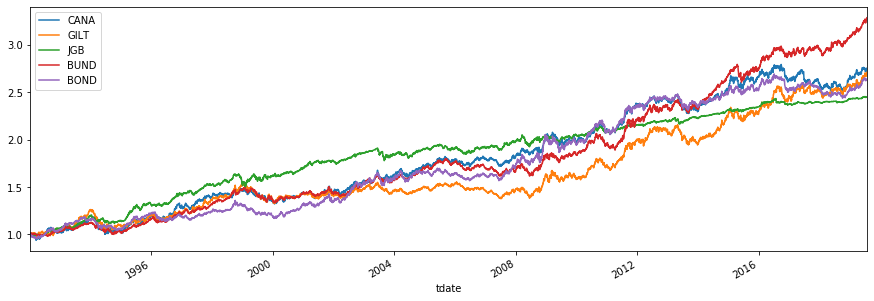

In [8]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

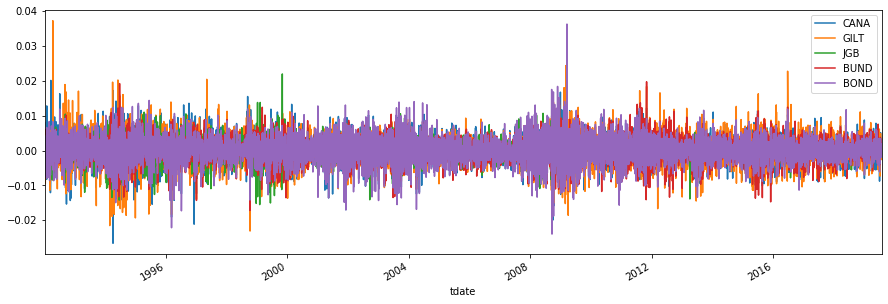

In [9]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [10]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 189, 252]

## 1. X

### average return

In [11]:
avg_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_ret['avg_ret_' + str(period)] = df_index_return.rolling(period).mean()

### average vol

In [12]:
avg_vol  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_vol['avg_vol_' + str(period)] = df_index_return.rolling(period).std()

### cum return

In [13]:
cum_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    cum_ret['cum_ret_' + str(period)] = df_index.pct_change(period)

In [14]:
df_mom_avg_ret = pd.concat(avg_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_avg_vol = pd.concat(avg_vol, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_cum_ret = pd.concat(cum_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

# CASE 0. 기존

<img src="result/IPM_PAST.png">

<img src="result/IPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [15]:
one_week = 5
one_month = 20

In [16]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

### binary - 50%

In [17]:
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [18]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [19]:
df_mom_cum_ret.reset_index(inplace=True)
df_mom_avg_ret.reset_index(inplace=True)
df_mom_avg_vol.reset_index(inplace=True)

df_join = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [20]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [21]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.672366	valid_1's binary_logloss: 0.672366
[20]	training's binary_logloss: 0.671772	valid_1's binary_logloss: 0.671772
[30]	training's binary_logloss: 0.671212	valid_1's binary_logloss: 0.671212
[40]	training's binary_logloss: 0.670656	valid_1's binary_logloss: 0.670656
[50]	training's binary_logloss: 0.670166	valid_1's binary_logloss: 0.670166
[60]	training's binary_logloss: 0.669701	valid_1's binary_logloss: 0.669701
[70]	training's binary_logloss: 0.66927	valid_1's binary_logloss: 0.66927
[80]	training's binary_logloss: 0.668864	valid_1's binary_logloss: 0.668864
[90]	training's binary_logloss: 0.668478	valid_1's binary_logloss: 0.668478
[100]	training's binary_logloss: 0.668097	valid_1's binary_logloss: 0.668097
[110]	training's binary_logloss: 0.667696	valid_1's binary_logloss: 0.667696
[120]	training's binary_logloss: 0.667351	valid_1's binary_logloss: 0.667351
[130]	training's binary_l

In [22]:
test_pred = model.predict(df_test_x.values)

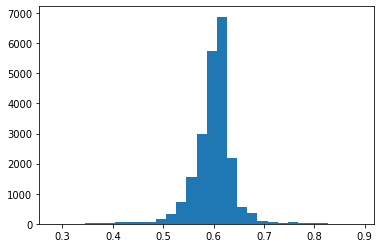

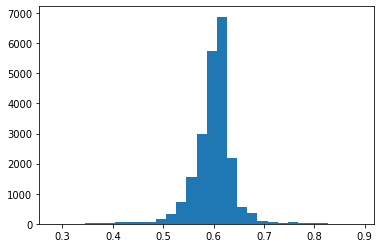

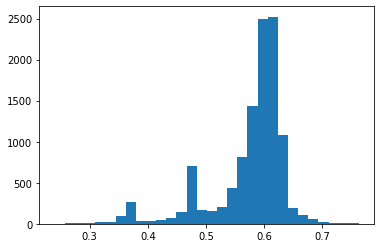

In [23]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [24]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [26]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [27]:
df_index_sub = df_index.loc['1994':]

In [28]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [29]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [30]:
strategy.set_rebalance_period(freq='week', rebalance_weekday=1) 

2019-10-30 19:44:15,891 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [31]:
tester = Tester(strategy)

In [32]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [33]:
strategy.set_portfolio_parameter(cs_strategy_type='vol')
strategy.make_portfolio()

2019-10-30 19:44:15,920 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:44:15,921 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:44:15,921 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:44:21,508 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 19:44:21,508 - IPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 19:44:23,089 - IPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-30 19:44:23,094 - IPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTROL to TS POSITION
2019-10-30 19:44:24,098 - IPM - INFO - [STEP 5 - 2 - 4] MAKE FINAL TS POSITION
2019-10-30 19:44:24,101 - IPM - INFO - [STEP 5 - 3] MAKE CS POSITION
2019-10-30 19:44:24,101 - IPM - INFO - [STEP 5 - 3 - 1] TARGET VOL CONTROL to CS POSITION
2019-10-30 19:44:24,105 - IPM - INFO - [STEP 5 - 3 - 2] ALIGN CS POSITION WITH REBALANCE DAY
2019-10-30 19:44:30,398 - IPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITION
2019-10-30 19

### TRAIN

2019-10-30 19:44:31,573 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:44:31,574 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:44:31,581 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:44:31,588 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT


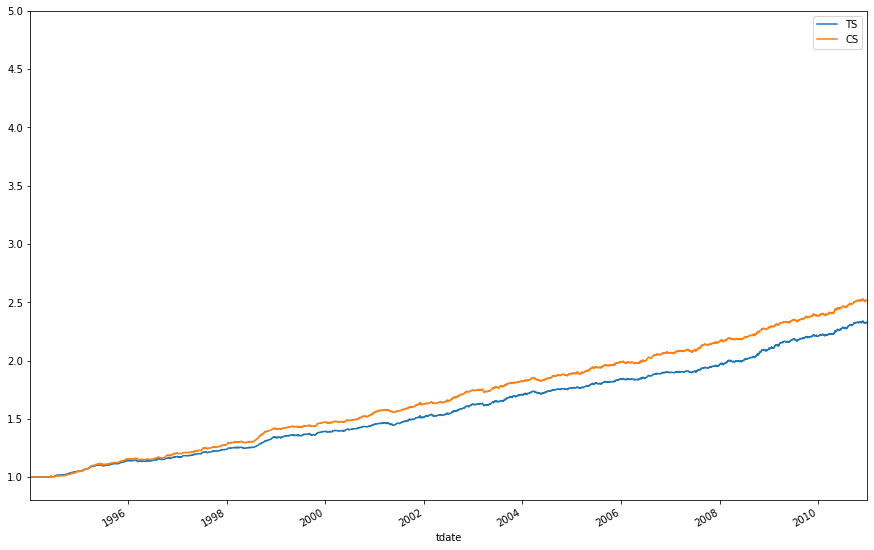

In [34]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-30 19:54:44,731 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:44,731 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:44,731 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:44,731 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:44,733 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:44,733 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:44,733 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:44,733 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:44,740 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:44,740 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:44,740 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:44,740 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:44,747 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:54:44,747 - IPM - INFO - [STEP 7]

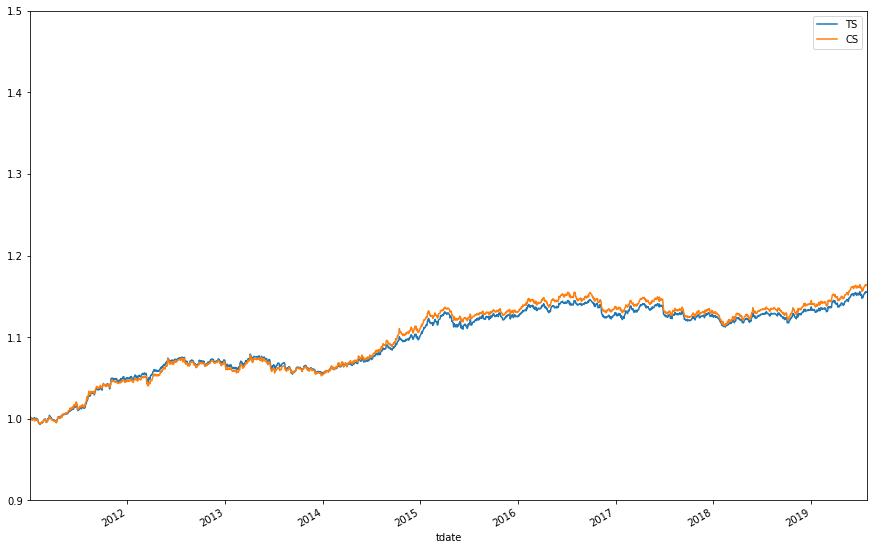

In [75]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [36]:
one_week = 5
one_month = 20

df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [37]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [38]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [39]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [40]:
df_join2 = pd.merge(df_y2, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_cum_ret, on=['tdate', 'ticker'])

In [41]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [42]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.634927	valid_1's binary_logloss: 0.634927
[20]	training's binary_logloss: 0.633547	valid_1's binary_logloss: 0.633547
[30]	training's binary_logloss: 0.632325	valid_1's binary_logloss: 0.632325
[40]	training's binary_logloss: 0.631262	valid_1's binary_logloss: 0.631262
[50]	training's binary_logloss: 0.630271	valid_1's binary_logloss: 0.630271
[60]	training's binary_logloss: 0.62923	valid_1's binary_logloss: 0.62923
[70]	training's binary_logloss: 0.628251	valid_1's binary_logloss: 0.628251
[80]	training's binary_logloss: 0.627377	valid_1's binary_logloss: 0.627377
[90]	training's binary_logloss: 0.626517	valid_1's binary_logloss: 0.626517
[100]	training's binary_logloss: 0.625668	valid_1's binary_logloss: 0.625668
[110]	training's binary_logloss: 0.624888	valid_1's binary_logloss: 0.624888
[120]	training's binary_logloss: 0.62404	valid_1's binary_logloss: 0.62404
[130]	training's binary_log

In [43]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([5.000e+00, 0.000e+00, 6.000e+00, 2.200e+01, 3.800e+01, 1.200e+02,
        1.930e+02, 1.660e+02, 1.800e+02, 2.030e+02, 3.280e+02, 3.760e+02,
        4.420e+02, 5.220e+02, 6.490e+02, 9.850e+02, 1.448e+03, 2.141e+03,
        3.095e+03, 4.523e+03, 6.867e+03, 7.173e+03, 2.258e+03, 8.530e+02,
        3.840e+02, 1.900e+02, 5.500e+01, 3.400e+01, 1.600e+01, 3.000e+00]),
 array([0.25131811, 0.2723889 , 0.2934597 , 0.31453049, 0.33560128,
        0.35667207, 0.37774286, 0.39881366, 0.41988445, 0.44095524,
        0.46202603, 0.48309682, 0.50416761, 0.52523841, 0.5463092 ,
        0.56737999, 0.58845078, 0.60952157, 0.63059237, 0.65166316,
        0.67273395, 0.69380474, 0.71487553, 0.73594632, 0.75701712,
        0.77808791, 0.7991587 , 0.82022949, 0.84130028, 0.86237108,
        0.88344187]),
 <a list of 30 Patch objects>)

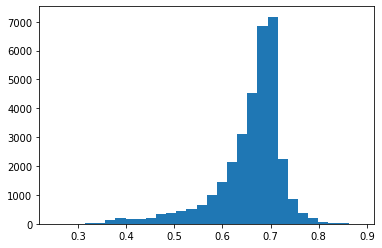

In [44]:
plt.hist(pred2, bins=30)

In [45]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [46]:
strategy2 = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy2.load_index_and_return(from_db=False, save_file=False)

strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'

strategy2.index.index.name = 'tdate'
strategy2.ret.index.name = 'tdate'

strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

2019-10-30 19:44:32,642 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:44:32,642 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:44:32,643 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:44:32,643 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:44:32,644 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 19:44:32,644 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [47]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='vol')
strategy2.make_portfolio()

2019-10-30 19:44:32,675 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:44:32,675 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:44:32,675 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:44:32,675 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:44:32,676 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:44:32,676 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:44:32,677 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:44:32,677 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:44:38,223 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 19:44:38,223 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 19:44:38,224 - IPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 19:44:38,224 - IPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 19:44:39,804 - IPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-30 19:44:39,804 - IPM - 

### TRAIN

2019-10-30 19:44:48,851 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:44:48,851 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:44:48,852 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:44:48,852 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:44:48,860 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:44:48,860 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:44:48,868 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:44:48,868 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT


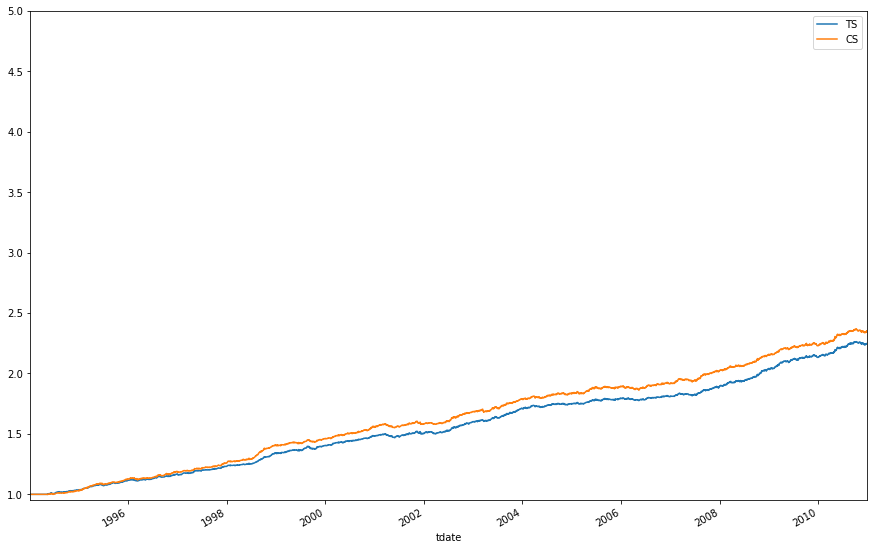

In [48]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-30 19:54:38,531 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:38,531 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:38,531 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:38,531 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:38,533 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:38,533 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:38,533 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:38,533 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:38,541 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:38,541 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:38,541 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:38,541 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:38,549 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:54:38,549 - IPM - INFO - [STEP 7]

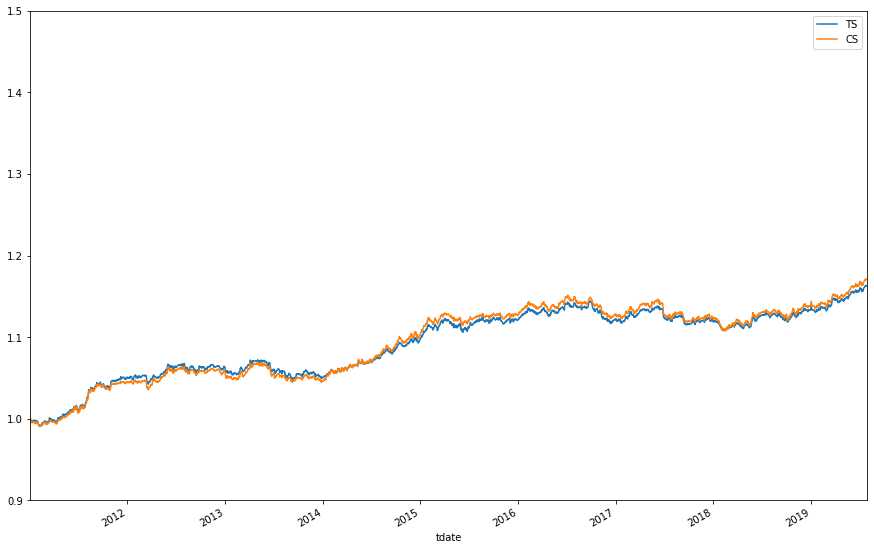

In [74]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))

# CASE 3. Case1을 Rolling으로 실행

In [50]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [51]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [52]:
models = []
train_preds = []
test_preds = []

In [53]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.672366	valid_1's binary_logloss: 0.672136
[20]	training's binary_logloss: 0.671772	valid_1's binary_logloss: 0.67166
[30]	training's binary_logloss: 0.671212	valid_1's binary_logloss: 0.671132
[40]	training's binary_logloss: 0.670656	valid_1's binary_logloss: 0.670668
[50]	training's binary_logloss: 0.670166	valid_1's binary_logloss: 0.670304
[60]	training's binary_logloss: 0.669701	valid_1's binary_logloss: 0.670044
[70]	training's binary_logloss: 0.66927	valid_1's binary_logloss: 0.669756
[80]	training's binary_logloss: 0.668864	valid_1's binary_logloss: 0.669676
[90]	training's binary_logloss: 0.668478	valid_1's binary_logloss: 0.669622
[100]	training's binary_logloss: 0.668097	valid_1's binary_logloss: 0.669641
[110]	training's binary_logloss: 0.667696	valid_1's binary_logloss: 0.669539
[120]	training's binary_logloss: 0.667351	valid_1's binary_logloss: 0.669584
[130]	training's binary_l

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.672314	valid_1's binary_logloss: 0.671742
[20]	training's binary_logloss: 0.671698	valid_1's binary_logloss: 0.670888
[30]	training's binary_logloss: 0.671152	valid_1's binary_logloss: 0.670275
[40]	training's binary_logloss: 0.670657	valid_1's binary_logloss: 0.669824
[50]	training's binary_logloss: 0.670167	valid_1's binary_logloss: 0.669323
[60]	training's binary_logloss: 0.669672	valid_1's binary_logloss: 0.668997
[70]	training's binary_logloss: 0.669215	valid_1's binary_logloss: 0.668666
[80]	training's binary_logloss: 0.668791	valid_1's binary_logloss: 0.668334
[90]	training's binary_logloss: 0.668401	valid_1's binary_logloss: 0.668336
[100]	training's binary_logloss: 0.668029	valid_1's binary_logloss: 0.66823
[110]	training's binary_logloss: 0.667645	valid_1's binary_logloss: 0.668133
[120]	training's binary_logloss: 0.667263	valid_1's binary_logloss: 0.668153
[130]	training's binary_

[250]	training's binary_logloss: 0.663671	valid_1's binary_logloss: 0.663116
[260]	training's binary_logloss: 0.663398	valid_1's binary_logloss: 0.663048
[270]	training's binary_logloss: 0.663135	valid_1's binary_logloss: 0.662961
[280]	training's binary_logloss: 0.662877	valid_1's binary_logloss: 0.662949
[290]	training's binary_logloss: 0.662627	valid_1's binary_logloss: 0.663014
[300]	training's binary_logloss: 0.662338	valid_1's binary_logloss: 0.662996
[310]	training's binary_logloss: 0.662101	valid_1's binary_logloss: 0.662957
[320]	training's binary_logloss: 0.661851	valid_1's binary_logloss: 0.663012
[330]	training's binary_logloss: 0.661579	valid_1's binary_logloss: 0.66298
[340]	training's binary_logloss: 0.661325	valid_1's binary_logloss: 0.66299
[350]	training's binary_logloss: 0.661084	valid_1's binary_logloss: 0.663046
[360]	training's binary_logloss: 0.660815	valid_1's binary_logloss: 0.663012
[370]	training's binary_logloss: 0.660552	valid_1's binary_logloss: 0.66308
[3

[270]	training's binary_logloss: 0.663345	valid_1's binary_logloss: 0.671621
[280]	training's binary_logloss: 0.663124	valid_1's binary_logloss: 0.671711
[290]	training's binary_logloss: 0.662896	valid_1's binary_logloss: 0.671851
[300]	training's binary_logloss: 0.662639	valid_1's binary_logloss: 0.671908
[310]	training's binary_logloss: 0.662404	valid_1's binary_logloss: 0.671939
[320]	training's binary_logloss: 0.662178	valid_1's binary_logloss: 0.67201
[330]	training's binary_logloss: 0.661965	valid_1's binary_logloss: 0.672126
[340]	training's binary_logloss: 0.661741	valid_1's binary_logloss: 0.672153
[350]	training's binary_logloss: 0.661528	valid_1's binary_logloss: 0.672215
[360]	training's binary_logloss: 0.661286	valid_1's binary_logloss: 0.672241
[370]	training's binary_logloss: 0.661063	valid_1's binary_logloss: 0.672274
[380]	training's binary_logloss: 0.660842	valid_1's binary_logloss: 0.672301
[390]	training's binary_logloss: 0.660616	valid_1's binary_logloss: 0.672323


[320]	training's binary_logloss: 0.662618	valid_1's binary_logloss: 0.674672
[330]	training's binary_logloss: 0.662406	valid_1's binary_logloss: 0.674731
[340]	training's binary_logloss: 0.662206	valid_1's binary_logloss: 0.67477
[350]	training's binary_logloss: 0.662	valid_1's binary_logloss: 0.674849
[360]	training's binary_logloss: 0.6618	valid_1's binary_logloss: 0.674961
[370]	training's binary_logloss: 0.661598	valid_1's binary_logloss: 0.675032
[380]	training's binary_logloss: 0.661392	valid_1's binary_logloss: 0.675086
[390]	training's binary_logloss: 0.661176	valid_1's binary_logloss: 0.675219
[400]	training's binary_logloss: 0.660957	valid_1's binary_logloss: 0.675315
[410]	training's binary_logloss: 0.660753	valid_1's binary_logloss: 0.675434
[420]	training's binary_logloss: 0.660553	valid_1's binary_logloss: 0.675491
[430]	training's binary_logloss: 0.660325	valid_1's binary_logloss: 0.675522
[440]	training's binary_logloss: 0.660119	valid_1's binary_logloss: 0.675643
[450]

In [54]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([2.000e+00, 2.000e+01, 1.600e+01, 2.300e+01, 6.000e+00, 1.000e+01,
        2.800e+01, 6.500e+01, 1.340e+02, 2.860e+02, 3.400e+02, 3.680e+02,
        4.870e+02, 4.290e+02, 5.910e+02, 7.500e+02, 1.340e+03, 2.043e+03,
        2.325e+03, 1.393e+03, 2.640e+02, 9.400e+01, 7.000e+01, 4.200e+01,
        6.000e+00, 3.000e+00, 8.000e+00, 0.000e+00, 6.000e+00, 1.100e+01]),
 array([0.33904378, 0.35398912, 0.36893446, 0.38387979, 0.39882513,
        0.41377047, 0.42871581, 0.44366115, 0.45860649, 0.47355183,
        0.48849717, 0.50344251, 0.51838785, 0.53333319, 0.54827853,
        0.56322386, 0.5781692 , 0.59311454, 0.60805988, 0.62300522,
        0.63795056, 0.6528959 , 0.66784124, 0.68278658, 0.69773192,
        0.71267726, 0.7276226 , 0.74256794, 0.75751327, 0.77245861,
        0.78740395]),
 <a list of 30 Patch objects>)

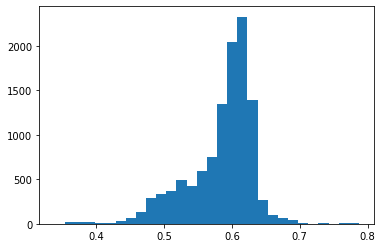

In [55]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [56]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [57]:
strategy3 = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy3.load_index_and_return(from_db=False, save_file=False)

strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'

strategy3.index.index.name = 'tdate'
strategy3.ret.index.name = 'tdate'

strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-10-30 19:44:53,644 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:44:53,644 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:44:53,644 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:44:53,646 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:44:53,646 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:44:53,646 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:44:53,647 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 19:44:53,647 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 19:44:53,647 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [58]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='vol')
strategy3.make_portfolio()

2019-10-30 19:44:53,679 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:44:53,679 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:44:53,679 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:44:53,681 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:44:53,681 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:44:53,681 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:44:53,682 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:44:53,682 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:44:53,682 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:44:53,683 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:44:53,683 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:44:53,683 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:44:59,361 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 19:44:59,361 - IPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 19:44:59,361 - IPM -

2019-10-30 19:54:29,898 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:29,898 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:29,898 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:29,898 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:29,900 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:29,900 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:29,900 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:29,900 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:29,906 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:29,906 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:29,906 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:29,906 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:29,913 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:54:29,913 - IPM - INFO - [STEP 7]

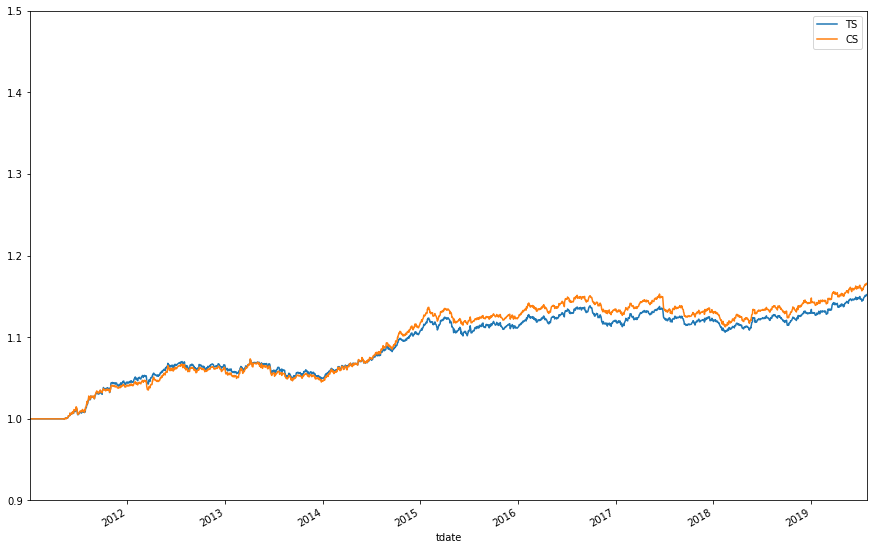

In [72]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))

# CASE 4. CASE 2를 ROLLING으로 실행

In [60]:
models = []
train_preds = []
test_preds = []

In [61]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.634927	valid_1's binary_logloss: 0.68006
[20]	training's binary_logloss: 0.633547	valid_1's binary_logloss: 0.678426
[30]	training's binary_logloss: 0.632325	valid_1's binary_logloss: 0.676921
[40]	training's binary_logloss: 0.631262	valid_1's binary_logloss: 0.675692
[50]	training's binary_logloss: 0.630271	valid_1's binary_logloss: 0.674029
[60]	training's binary_logloss: 0.62923	valid_1's binary_logloss: 0.67293
[70]	training's binary_logloss: 0.628251	valid_1's binary_logloss: 0.672096
[80]	training's binary_logloss: 0.627377	valid_1's binary_logloss: 0.671696
[90]	training's binary_logloss: 0.626517	valid_1's binary_logloss: 0.67116
[100]	training's binary_logloss: 0.625668	valid_1's binary_logloss: 0.670842
[110]	training's binary_logloss: 0.624888	valid_1's binary_logloss: 0.670634
[120]	training's binary_logloss: 0.62404	valid_1's binary_logloss: 0.669611
[130]	training's binary_logl

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[80]	training's binary_logloss: 0.627152	valid_1's binary_logloss: 0.66845
[90]	training's binary_logloss: 0.626291	valid_1's binary_logloss: 0.666716
[100]	training's binary_logloss: 0.625515	valid_1's binary_logloss: 0.665907
[110]	training's binary_logloss: 0.624798	valid_1's binary_logloss: 0.665738
[120]	training's binary_logloss: 0.624107	valid_1's binary_logloss: 0.665511
[130]	training's binary_logloss: 0.623435	valid_1's binary_logloss: 0.665651
[140]	training's binary_logloss: 0.622798	valid_1's binary_logloss: 0.665698
[150]	training's binary_logloss: 0.622149	valid_1's binary_logloss: 0.665678
[160]	training's binary_logloss: 0.621508	valid_1's binary_logloss: 0.665734
[170]	training's binary_logloss: 0.62095	valid_1's binary_logloss: 0.665858
[180]	training's binary_logloss: 0.620383	valid_1's binary_logloss: 0.665786
[190]	training's binary_logloss: 0.619812	valid_1's binary_logloss: 0.665981
[200]	training's binary_logloss: 0.619297	valid_1's binary_logloss: 0.666262
[2

[300]	training's binary_logloss: 0.615646	valid_1's binary_logloss: 0.667113
[310]	training's binary_logloss: 0.615141	valid_1's binary_logloss: 0.667164
[320]	training's binary_logloss: 0.614702	valid_1's binary_logloss: 0.66719
[330]	training's binary_logloss: 0.614296	valid_1's binary_logloss: 0.667624
[340]	training's binary_logloss: 0.613832	valid_1's binary_logloss: 0.667558
[350]	training's binary_logloss: 0.613433	valid_1's binary_logloss: 0.667664
[360]	training's binary_logloss: 0.612974	valid_1's binary_logloss: 0.668079
[370]	training's binary_logloss: 0.61252	valid_1's binary_logloss: 0.668131
[380]	training's binary_logloss: 0.612149	valid_1's binary_logloss: 0.668038
[390]	training's binary_logloss: 0.611686	valid_1's binary_logloss: 0.66807
[400]	training's binary_logloss: 0.611319	valid_1's binary_logloss: 0.668116
[410]	training's binary_logloss: 0.610873	valid_1's binary_logloss: 0.668159
[420]	training's binary_logloss: 0.61048	valid_1's binary_logloss: 0.668171
[43

[400]	training's binary_logloss: 0.611066	valid_1's binary_logloss: 0.683315
[410]	training's binary_logloss: 0.610651	valid_1's binary_logloss: 0.683722
[420]	training's binary_logloss: 0.610196	valid_1's binary_logloss: 0.684279
[430]	training's binary_logloss: 0.609749	valid_1's binary_logloss: 0.684156
[440]	training's binary_logloss: 0.609308	valid_1's binary_logloss: 0.684724
[450]	training's binary_logloss: 0.608862	valid_1's binary_logloss: 0.684913
[460]	training's binary_logloss: 0.608437	valid_1's binary_logloss: 0.685139
[470]	training's binary_logloss: 0.608072	valid_1's binary_logloss: 0.685726
[480]	training's binary_logloss: 0.6077	valid_1's binary_logloss: 0.685863
[490]	training's binary_logloss: 0.607307	valid_1's binary_logloss: 0.685881
[500]	training's binary_logloss: 0.60696	valid_1's binary_logloss: 0.686088
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.60696	valid_1's binary_logloss: 0.686088
Training until validation scores

[440]	training's binary_logloss: 0.61102	valid_1's binary_logloss: 0.683113
[450]	training's binary_logloss: 0.610667	valid_1's binary_logloss: 0.683279
[460]	training's binary_logloss: 0.610291	valid_1's binary_logloss: 0.683692
[470]	training's binary_logloss: 0.609972	valid_1's binary_logloss: 0.683724
[480]	training's binary_logloss: 0.60969	valid_1's binary_logloss: 0.683906
[490]	training's binary_logloss: 0.609347	valid_1's binary_logloss: 0.684231
[500]	training's binary_logloss: 0.60902	valid_1's binary_logloss: 0.684302
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.60902	valid_1's binary_logloss: 0.684302
Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.634775	valid_1's binary_logloss: 0.693459
[20]	training's binary_logloss: 0.633303	valid_1's binary_logloss: 0.692018
[30]	training's binary_logloss: 0.632043	valid_1's binary_logloss: 0.690773
[40]	training's binary_logloss: 0.630934	valid_1's

In [62]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [63]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [64]:
strategy4 = IRStrategy(strategy_name="IPM", asset_type="IR")
strategy4.load_index_and_return(from_db=False, save_file=False)

strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'

strategy4.index.index.name = 'tdate'
strategy4.ret.index.name = 'tdate'

strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-10-30 19:45:06,324 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:45:06,324 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:45:06,324 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:45:06,324 - IPM - INFO - [STEP 0] START LOGGING IPM
2019-10-30 19:45:06,326 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:45:06,326 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:45:06,326 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:45:06,326 - IPM - INFO - [STEP 1] LOAD DATA
2019-10-30 19:45:06,328 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 19:45:06,328 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 19:45:06,328 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 19:45:06,328 - IPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [65]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='vol')
strategy4.make_portfolio()

2019-10-30 19:45:06,370 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:45:06,370 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:45:06,370 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:45:06,370 - IPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 19:45:06,372 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:45:06,372 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:45:06,372 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:45:06,372 - IPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 19:45:06,374 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:45:06,374 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:45:06,374 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:45:06,374 - IPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 19:45:06,376 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:45:06,376 - IPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 19:45:06,376 - IPM - INFO -

2019-10-30 19:54:22,026 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:22,026 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:22,026 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:22,026 - IPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:54:22,028 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:22,028 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:22,028 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:22,028 - IPM - INFO - [STEP 6 - 1] BACKTEST IPM TIME SERIES
2019-10-30 19:54:22,035 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:22,035 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:22,035 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:22,035 - IPM - INFO - [STEP 6 - 2] BACKTEST IPM CROSS SECTIONAL
2019-10-30 19:54:22,043 - IPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:54:22,043 - IPM - INFO - [STEP 7]

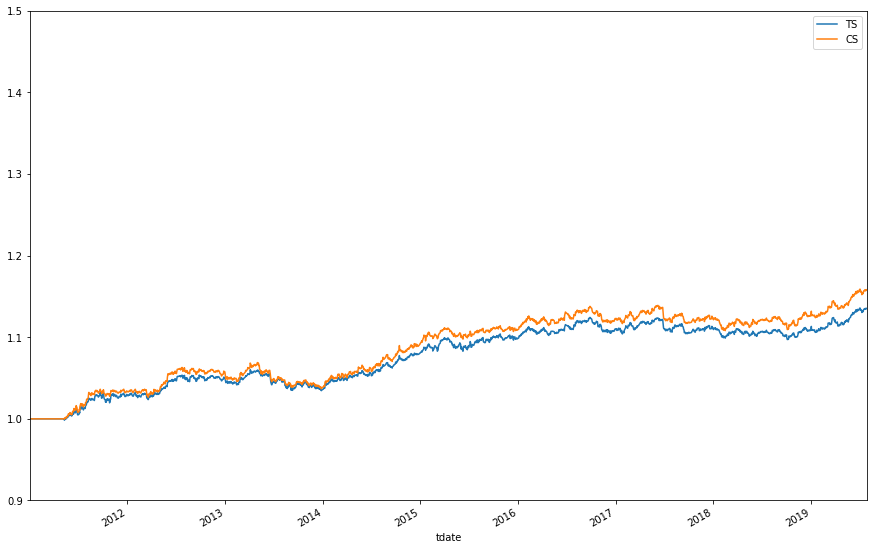

In [71]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))